# Neural Networks I

We will first train a bisic linear regression model ona toy data set without using any modules in "torch.nn".

The most commonly used approach for building an NN in PyTorch is through "nn.Module", which allows layers to be stacked to form a network. We will cover this later on.

#### Building a linear regression model

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt

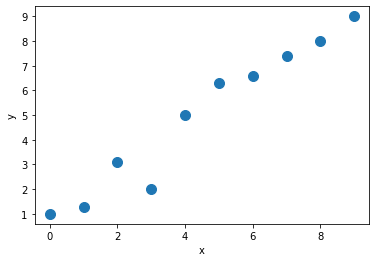

In [18]:
X_train = np.arange(10, dtype='float32').reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 
                    7.4, 8.0, 9.0], dtype='float32')

plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')

#plt.savefig('figures/12_07.pdf')
plt.show()

In [19]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)
y_train = torch.from_numpy(y_train)

train_ds = TensorDataset(X_train_norm, y_train) #joint data sets

batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

Next, we will fit a linear regression model using "torch.nn". To learn the parameters, we use SGD which we will code here. Later, we use the SGD from "torch.optim" package. Rather than manually calculating the gradients, we use "torch.autograd.backward".

In [20]:
torch.manual_seed(1)
weight = torch.randn(1)
weight.requires_grad_()
bias = torch.zeros(1, requires_grad=True)
 
def loss_fn(input, target):
    return (input-target).pow(2).mean()  # Mean Squared Error (MSE)

def model(xb):
    return xb @ weight + bias

learning_rate = 0.001 # step size
num_epochs = 200
log_epochs = 10

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()

        with torch.no_grad(): # with is used for exceptation handling 
            #(torch.no_grad is for memory consumption. It will have 
            # require_grad=False, even when the inputs have requires_grad=True, 
            # for any function of current variables.)
            weight -= weight.grad * learning_rate
            bias -= bias.grad * learning_rate
            weight.grad.zero_() # sets the gradient to zero
            bias.grad.zero_()
 
    if epoch % log_epochs==0:   # % is the Modulus operator in python
        print(f'Epoch {epoch}  Loss {loss.item():.4f}') # item provides the last value

Epoch 0  Loss 45.0782
Epoch 10  Loss 26.4366
Epoch 20  Loss 1.5918
Epoch 30  Loss 14.1307
Epoch 40  Loss 11.6038
Epoch 50  Loss 6.3084
Epoch 60  Loss 0.6349
Epoch 70  Loss 3.1374
Epoch 80  Loss 1.9999
Epoch 90  Loss 0.3133
Epoch 100  Loss 0.7653
Epoch 110  Loss 1.0039
Epoch 120  Loss 0.0235
Epoch 130  Loss 0.5176
Epoch 140  Loss 0.0759
Epoch 150  Loss 1.8789
Epoch 160  Loss 0.0008
Epoch 170  Loss 0.0866
Epoch 180  Loss 0.0646
Epoch 190  Loss 0.0011


Let's look at the trained model and plot it:

Final Parameters: 2.6696107387542725 4.879678249359131


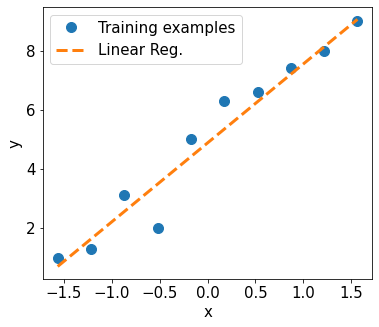

In [5]:
print('Final Parameters:', weight.item(), bias.item())
 
X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy() # creates a new tensor detached 
# from the current graph (will not require gradient)


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
 
#plt.savefig('figures/12_08.pdf')

plt.show()

#### Model training via the torch.nn and torch.optim modules
Writing the loss function and gradient updates can be a repeatable task across different projects. The torch.nn module provides a set of loss functions, and torch.optim supports most commonly used optimization algorithms that can be called to update the parameters based on the computed gradients. To see how they work, let’s create a new MSE loss function and a stochastic gradient descent optimizer:

In [21]:
import torch.nn as nn

input_size = 1
output_size = 1
model = nn.Linear(input_size, output_size) # linear layer instead of manually definning it

loss_fn = nn.MSELoss(reduction='mean') # average of the individual losses

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Now, we can simply call the step() method of the optimizer to train the model. We can pass a batched dataset.

In [22]:
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # 1. Generate predictions
        pred = model(x_batch)[:, 0] 

        # 2. Calculate loss
        loss = loss_fn(pred, y_batch)

        # 3. Compute gradients
        loss.backward()

        # 4. Update parameters using gradients
        optimizer.step()

        # 5. Reset the gradients to zero
        optimizer.zero_grad()
        
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 24.6684
Epoch 10  Loss 29.1377
Epoch 20  Loss 20.9207
Epoch 30  Loss 0.1257
Epoch 40  Loss 12.4922
Epoch 50  Loss 1.7845
Epoch 60  Loss 7.6425
Epoch 70  Loss 2.5606
Epoch 80  Loss 0.0157
Epoch 90  Loss 0.7548
Epoch 100  Loss 0.8412
Epoch 110  Loss 0.4923
Epoch 120  Loss 0.0823
Epoch 130  Loss 0.0794
Epoch 140  Loss 0.0891
Epoch 150  Loss 0.0973
Epoch 160  Loss 0.1043
Epoch 170  Loss 0.1103
Epoch 180  Loss 0.0009
Epoch 190  Loss 0.0764


Check the final results:

Final Parameters: 2.6496422290802 4.87706995010376


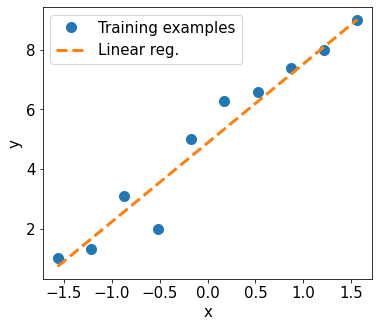

In [23]:
print('Final Parameters:', model.weight.item(), model.bias.item())
 
X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
 
#plt.savefig('ch12-linreg-2.pdf')

plt.show()

### Building a multilayer perceptron for classifying flowers in the Iris dataset

In [8]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 

iris = load_iris()
X = iris['data']
y = iris['target']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1./3, random_state=1)

Next, we standardize the features (mean centering and dividing by the standard deviation) and create a PyTorch Dataset for the training set and a corresponding DataLoader:

In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import torch

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train) 

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

Using the "nn.Module" class, we can stack a few layers and build an NN. You can see the list of all the layers that are already available at https://pytorch.org/docs/stable/nn.html. For this problem, we are going to use the Linear layer, which is also known as a fully connected layer or dense layer, and can be best represented by $f(wx + b)$.

In [12]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__() # initialize the super class
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

    def forward(self, x):
        x = self.layer1(x)  #W^1*x+b^1
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x) #supports multiclass classification
        return x
    
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
 
model = Model(input_size, hidden_size, output_size)

learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss() 
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

The softmax function above has the form $p(z_i)=e^{z_i}/\sum_{j=1}^M e^{z_j}$ and the cross-entropy loss is $-\sum_{k=1}^Kp(k)\log(\hat{p}(k))$. Next, we train the model.

In [13]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()  # Adam
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

The loss_hist and accuracy_hist lists keep the training loss and the training accuracy after each epoch. We can use this to visualize the learning curves as follows:

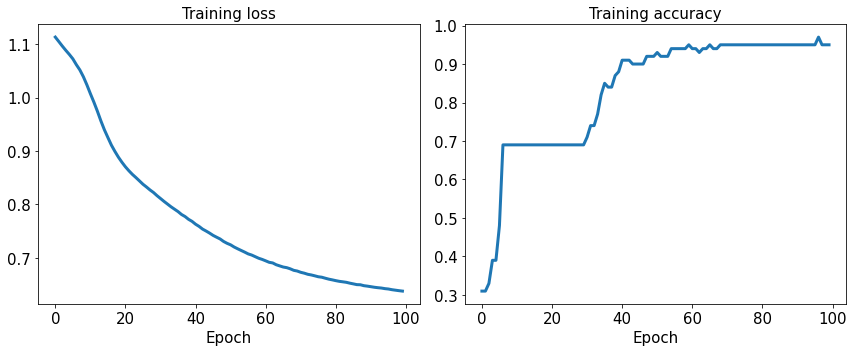

In [14]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

#plt.savefig('figures/12_09.pdf')
 
plt.show()

##### Evaluating the trained model on the test dataset

In [15]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test) 
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800
